In [1]:
from tools import *

## Create draft model from template iML1515
* 1. use Bi-directional Best Hit to identify the ortholog pairs between halomonas and E coli
* 2. get all reactions associated with all these genes
* 3. For those reactions with missing genes in the gr rule, try to find homologes in _H.TD01_ based on the same identity and coverage thresholds (Not BBH). The coverage threshold used in this study is 45%
* 4. resolve gr rules.

In [2]:
### Run pipeline for reconstruction of draft model from template model 

In [3]:
template_model = load_ecoli_model('../../../ComplementaryData/iML1515.mat',
                                  '../../../ComplementaryData/iML1515.xml')

Using license file /Users/gangl/gurobi.lic
Academic license - for non-commercial use only


In [4]:
# blast
do_blast('../../../ComplementaryData/protein_sequences_v3.0.fasta',
         '../../../ComplementaryData/orf_iML1515_formated.fasta')

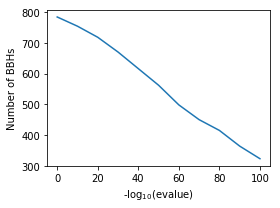

In [5]:
# BBH, try different evalues
evalues =  np.arange(0,110,10,dtype=float)
BBH_nums = list()
for evalue in evalues:
    BBH = extract_BBHs('../Results/bidirectional_blast.tab',10**(-evalue))
    BBH_nums.append(len(BBH))
plt.figure(figsize=(4,3))
plt.plot(evalues,BBH_nums)
plt.xlabel('-log$_{10}$(evalue)')
plt.ylabel('Number of BBHs')
plt.tight_layout()
plt.show()

In [6]:
BBHs = extract_BBHs('../Results/bidirectional_blast.tab',1e-3,True)

Number of homologs for query genes (evalue = 0.001): 1288
Number of homologs for target genes (evalue = 0.001): 1120
Number of BBHs (evalue = 0.001): 774


In [7]:
# Build first template model
candidate_rxns = get_all_rxns_in_BBH(template_model, BBHs)
model_from_template = build_model_from_template(candidate_rxns,BBHs,True)

Number of candiate reactions: 1290
Number of reactions: 1290
Number of metabolits: 1242
Number of compartments: 3 {'c': '', 'p': '', 'e': ''}
Number of genes: 900
Number of missing genes: 133
Number of reactions with missing genes: 122



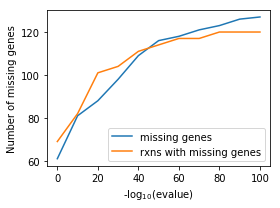

In [8]:
# test different evalues to update missing genes
evalues =  np.arange(0,110,10,dtype=float)
missing_genes = list()
rxns_with_missing_genes = list()
for evalue in evalues:
    model_from_template2 = update_missing_genes(model_from_template,10**(-evalue))
    missing_genes.append(len([gene for gene in model_from_template2.genes if 'missing' in gene.id]))
    rxns_with_missing_genes.append(len([rxn for rxn in model_from_template2.reactions if 'missing' in rxn.gene_reaction_rule]))
plt.figure(figsize=(4,3))
plt.plot(evalues,missing_genes,label='missing genes')
plt.plot(evalues,rxns_with_missing_genes,label='rxns with missing genes')
plt.xlabel('-log$_{10}$(evalue)')
plt.ylabel('Number of missing genes')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
model_from_template2 = update_missing_genes(model_from_template,1e-3,True)

Number of reactions: 1290
Number of metabolits: 1242
Number of compartments: 3 {'c': '', 'p': '', 'e': ''}
Number of genes: 859
Number of missing genes: 73
Number of reactions with missing genes: 75



In [10]:
k = 0
g = 0
b = 0
for rxn in model_from_template2.reactions:
    if rxn.annotation.get('biocyc') is not None: k += 1
    if rxn.annotation.get('kegg.reaction') is not None: g += 1
    if rxn.annotation.get('biocyc') is not None and rxn.annotation.get('kegg.reaction') is not None: b += 1
print('Number of reactions with MetaCyc id:',k,'/',len(model_from_template2.reactions))
print('Number of reactions with KEGG id:',g,'/',len(model_from_template2.reactions))
print('Number of reactions with both Metacyc and KEGG id:',b,'/',len(model_from_template2.reactions))

Number of reactions with MetaCyc id: 567 / 1290
Number of reactions with KEGG id: 527 / 1290
Number of reactions with both Metacyc and KEGG id: 462 / 1290


In [11]:
and_or_rxns = 0
rxns_with_missing_genes = 0
for rxn in model_from_template2.reactions:
    gr = rxn.gene_reaction_rule
    if ' and ' in gr and ' or ' in gr: 
        and_or_rxns += 1
    if '_missing' in gr: 
        rxns_with_missing_genes += 1
        print(rxn.id,rxn.gene_reaction_rule)
        print(rxn.reaction)
        print()
        
print('and or rxns: {0}/{1}'.format(and_or_rxns,len(model_from_template2.reactions)))
print('reactions with missing genes: {0}/{1}'.format(rxns_with_missing_genes,len(model_from_template2.reactions)))

FEENTERabcpp TD01GL002874 and TD01GL002875 and TD01GL002876 and b0592_missing
atp_c + feenter_p + h2o_c --> adp_c + feenter_c + h_c + pi_c

DHBSZ3FEabcpp TD01GL002874 and TD01GL002875 and TD01GL002876 and b0592_missing
atp_c + fe3dhbzs3_p + h2o_c --> adp_c + fe3dhbzs3_c + h_c + pi_c

PFL ( TD01GL002632 and b3114_missing ) or ( TD01GL002632 and b0903_missing ) or ( TD01GL002632 and b0903_missing and b2579_missing )
coa_c + pyr_c --> accoa_c + for_c

OBTFL ( TD01GL002632 and b3114_missing ) or ( TD01GL002632 and b0903_missing ) or ( TD01GL002632 and b0903_missing and b2579_missing )
2obut_c + coa_c --> for_c + ppcoa_c

PPPNDO TD01GL000421 and TD01GL003742 and b2539_missing and b2540_missing
h_c + nadh_c + o2_c + pppn_c --> cechddd_c + nad_c

CINNDO TD01GL000421 and TD01GL003742 and b2539_missing and b2540_missing
cinnm_c + h_c + nadh_c + o2_c --> cenchddd_c + nad_c

TGBPA TD01GL000048 and b3132_missing
tagdp__D_c <=> dhap_c + g3p_c

G3PAT160 TD01GL002266 and b4041_missing
glyc3p_c + palm

In [12]:
# remove reactions with missing genes from the draft model
model_from_template3 = remove_rxns_with_missing_genes(model_from_template2)

cobra.io.save_json_model(model_from_template2,
                        '../Results/halo_iML1515_template_with_missing_genes.json')
cobra.io.save_json_model(model_from_template3,
                    '../Results/halo_iML1515_template_without_missing_genes.json')

Number of reactions: 1215
Number of metabolits: 1173
Number of compartments: 3 {'c': '', 'p': '', 'e': ''}
Number of genes: 751
Number of missing genes: 0
Number of reactions with missing genes: 0

